# Zindi | Digital Green Crop Yield Estimate Challenge

This notebook is my solution in the [Digital Green Crop Yield Estimate Challenge](https://zindi.africa/competitions/digital-green-crop-yield-estimate-challenge) hosted by Zindi.<br/><br/>
The objective of this challenge is to create a machine learning solution to predict rice crop yields in India. The goal is to empower these farmers and break the cycle of poverty and malnutrition.

Here's a summary of the notebook:
* [I. My Solution](#chapter1)
* [II. Data pre-processing](#chapter2)
    * [II. 1. Imbalanced features](#section_2_1)
    * [II. 2. Outliers](#section_2_3)
        * [II. 2. a. Outliers in the input variables](#sub_section_2_3_1)
        * [II. 2. b. Outliers in the target variables](#sub_section_2_3_2)
    * [II. 3. Missing values](#section_2_2) 
    * [II. 4. Categorical encoding](#section_2_4)
    * [II. 5. Feature engineering](#section_2_5)
        * [II. 5. a. Multiplication by 10 problem](#sub_section_2_5_1)
        * [II. 5. b. Remaining outliers in the Yield problem](#sub_section_2_5_2)
    * [II. 6. Feature selection](#section_2_6)
* [III. Modeling](#chapter3)
* [IV. Further processing](#chapter4)
    * [1st modifications](#section_4_1)
    * [2nd modifications](#section_4_2)
* [V. Submission](#chapter5)

## I. My Solution <a id="chapter1"></a>

This schema summarizes my solution: 

![Schema](schema/DigitalCropYield_2.drawio.png)


## II. Data pre-processing <a id="chapter2"></a>

In [1]:
# Essential imports
import numpy as np 
import pandas as pd 
from tqdm import tqdm

# Visualization
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_theme()
sns.set_context("paper")
colors = sns.color_palette()

# Model selection
from sklearn.model_selection import train_test_split

# Models
import catboost

# Cross validation
from sklearn.model_selection import KFold

# Metrics
from sklearn.metrics import mean_squared_error

# Feature selection
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Encoding
import category_encoders as ce

# Similarity check
from sklearn.metrics.pairwise import cosine_similarity

# Load files
data_path = 'data/'
train_df = pd.read_csv(data_path + 'Train.csv')
test_df = pd.read_csv(data_path + 'Test.csv')
submission = pd.read_csv(data_path + 'SampleSubmission.csv')
var_desc = pd.read_csv(data_path + 'VariableDescription.csv')

### II. 1. Imbalanced features <a id="section_2_1"></a>

Under-represented categories within the ‘SeedlingsPerPit’ and ‘TransplantingIrrigationHours’ features have been identified. To rectify this, these categories will be merged into the smallest existing category among the under-represented ones.

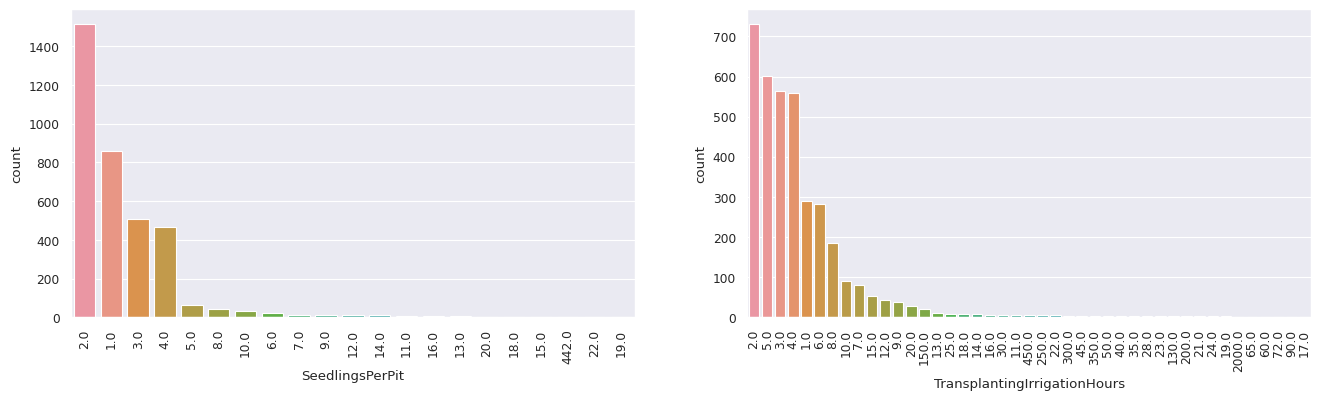

In [2]:
plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)
sns.countplot(x='SeedlingsPerPit', data=train_df, order=train_df['SeedlingsPerPit'].value_counts().index)
plt.xticks(rotation=90)

plt.subplot(1, 2, 2)
sns.countplot(x='TransplantingIrrigationHours', data=train_df, order=train_df['TransplantingIrrigationHours'].value_counts().index)
plt.xticks(rotation=90)

plt.show()

In [3]:
train_df.loc[train_df['SeedlingsPerPit'] >= 5.0, 'SeedlingsPerPit'] = 5.0
test_df.loc[test_df['SeedlingsPerPit'] >= 5.0, 'SeedlingsPerPit'] = 5.0

train_df.loc[train_df['TransplantingIrrigationHours'] >= 10.0, 'TransplantingIrrigationHours'] = 10.0
test_df.loc[test_df['TransplantingIrrigationHours'] >= 10.0, 'TransplantingIrrigationHours'] = 10.0

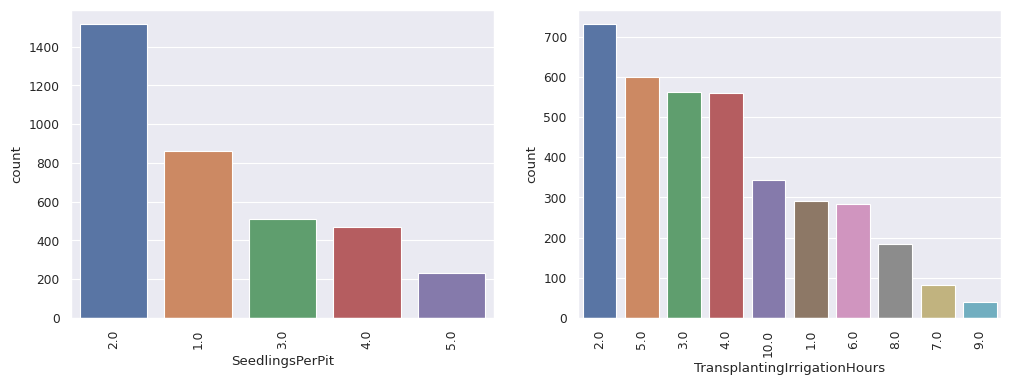

In [4]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.countplot(x='SeedlingsPerPit', data=train_df, order=train_df['SeedlingsPerPit'].value_counts().index)
plt.xticks(rotation=90)

plt.subplot(1, 2, 2)
sns.countplot(x='TransplantingIrrigationHours', data=train_df, order=train_df['TransplantingIrrigationHours'].value_counts().index)
plt.xticks(rotation=90)

plt.show()

### II. 2. Outliers <a id="section_2_2"></a>

#### II. 2. a. Outliers in the input variables <a id="sub_section_2_3_1"></a>

An examination of the input variables has revealed the presence of outliers in the following variables: CultLand, CropCultLand, TransIrriCost, CropOrgFYM, 1appDaysUrea. These outliers are distinctly visible in the subsequent boxplots. For the integrity of the dataset, these outliers will be excluded.

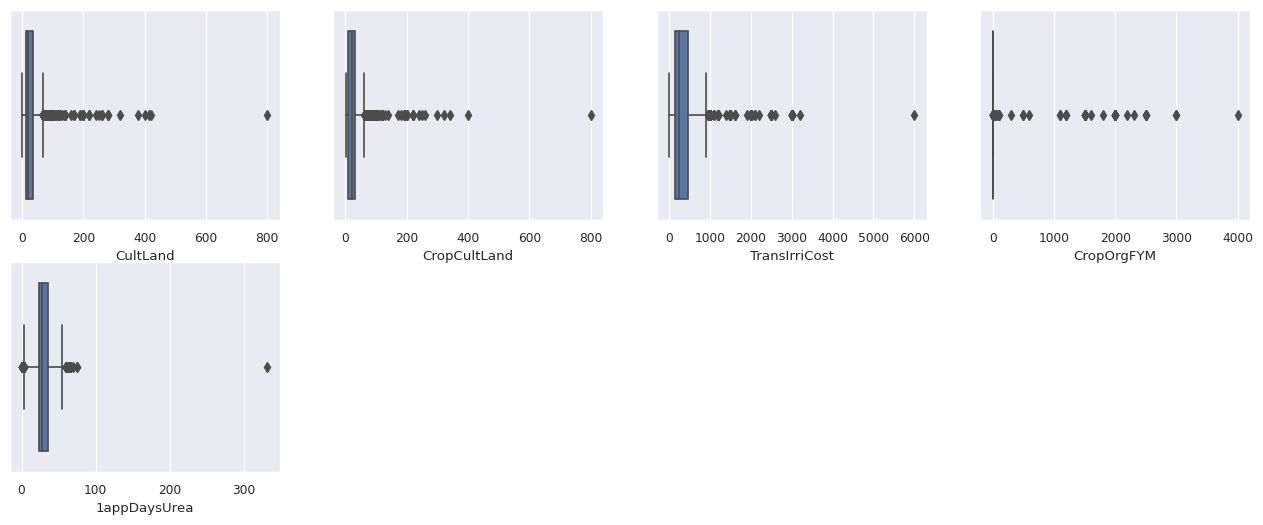

In [5]:
plt.figure(figsize=(16, 6))

plt.subplot(2, 4, 1)
sns.boxplot(x='CultLand', data=train_df)

plt.subplot(2, 4, 2)
sns.boxplot(x='CropCultLand', data=train_df)

plt.subplot(2, 4, 3)
sns.boxplot(x='TransIrriCost', data=train_df)

plt.subplot(2, 4, 4)
sns.boxplot(x='CropOrgFYM', data=train_df)

plt.subplot(2, 4, 5)
sns.boxplot(x='1appDaysUrea', data=train_df)

plt.show()

In [6]:
train_df = train_df[train_df["CultLand"] != 800]
train_df = train_df[train_df["CropCultLand"] != 800] 

train_df = train_df[train_df["TransIrriCost"] != 6000]

train_df = train_df[train_df["CropOrgFYM"] != 4000]

train_df = train_df[train_df["1appDaysUrea"] != 332]

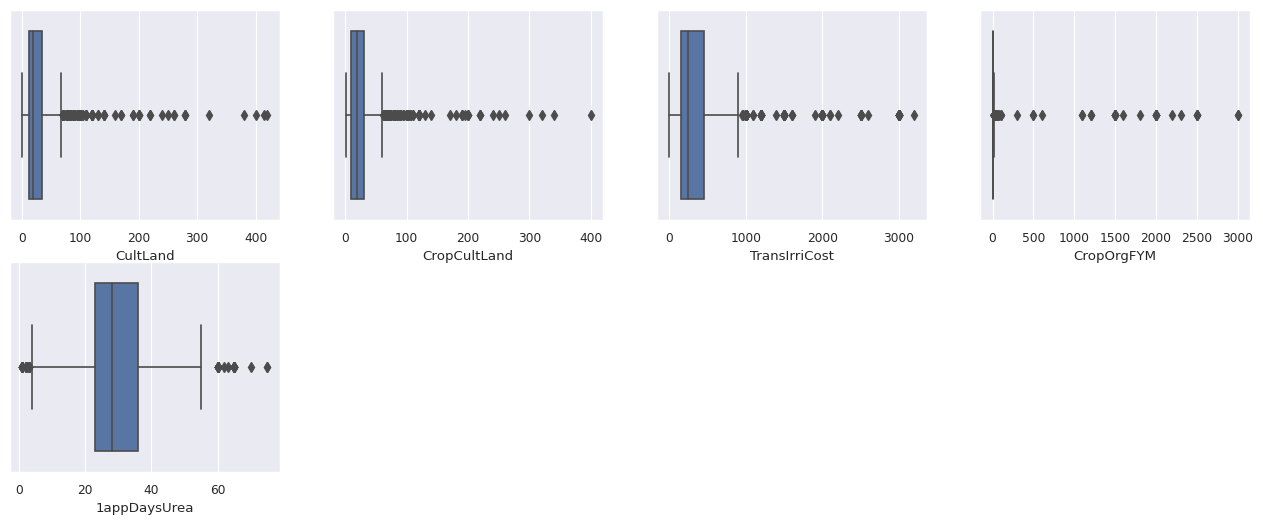

In [7]:
plt.figure(figsize=(16, 6))

plt.subplot(2, 4, 1)
sns.boxplot(x='CultLand', data=train_df)

plt.subplot(2, 4, 2)
sns.boxplot(x='CropCultLand', data=train_df)

plt.subplot(2, 4, 3)
sns.boxplot(x='TransIrriCost', data=train_df)

plt.subplot(2, 4, 4)
sns.boxplot(x='CropOrgFYM', data=train_df)

plt.subplot(2, 4, 5)
sns.boxplot(x='1appDaysUrea', data=train_df)

plt.show()

#### II. 2. b. Outliers in the target variables <a id="sub_section_2_3_2"></a>

The most significant challenge in this competition lies in the presence of certain values that appear to be multiplied by 10. At this stage, the indices of these values have been extracted for further analysis. It’s important to note that a threshold of 2500 has been set, as differences become more noticeable for yields exceeding this value. However, this is a hyperparameter that can be adjusted as needed.

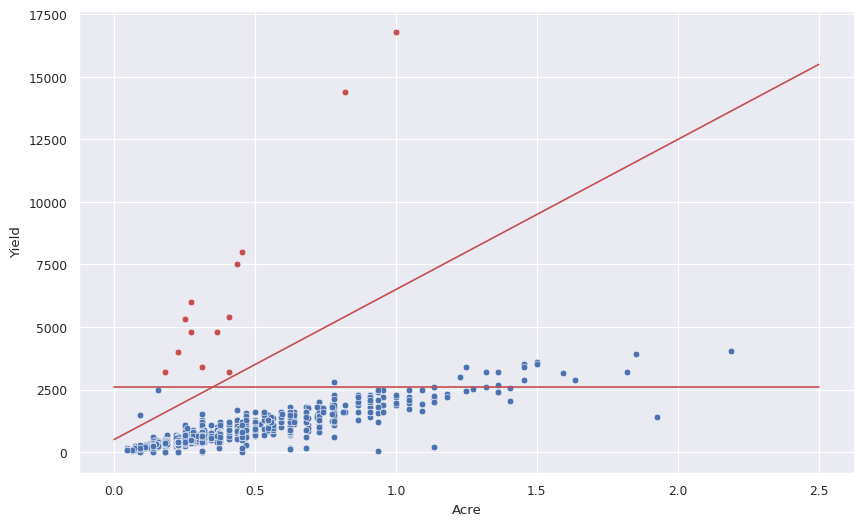

In [8]:
a = 6000
b = 500

def line(x):
    return a * x + b

_a = 0
_b = 2600

def _line(x):
    return _a * x + _b

over_line_df = train_df[(train_df['Yield'] >= train_df['Acre'].apply(line)) & (train_df['Yield'] > 2500)]

plt.figure(figsize=(10, 6))
sns.scatterplot(x='Acre', y='Yield', data=train_df)
sns.scatterplot(x='Acre', y='Yield', data=over_line_df, color = colors[3])

x = np.linspace(0, 2.5, 100)
y = line(x)

data = pd.DataFrame(data={'x': x, 'y': y})
sns.lineplot(x='x', y='y', data=data, color = colors[3])

_x = np.linspace(0, 2.5, 100)
_y = _line(x)

_data = pd.DataFrame(data={'x': _x, 'y': _y})
sns.lineplot(x='x', y='y', data=_data, color = colors[3])

plt.show()

In [9]:
# We extract the indexes of the outliers and we will use them later
is_10_indexes = over_line_df.index

train_df['is_10'] = 0
train_df.loc[is_10_indexes, 'is_10'] = 10
y_10 = train_df['is_10'].values
train_df = train_df.drop(['is_10'], axis=1)

### II. 3. Missing values <a id="section_2_3"></a>

For the numerical variables, missing values will be replaced by the KNNImputer. For the categorical variables, missing values will be replaced by the mode.

In [10]:
df = pd.concat([train_df, test_df], axis=0)
print("Initial missing values:", df.isnull().sum().sum())

y = df['Yield']
df = df.drop(['ID' , 'Yield'], axis=1)

numerical_df = df.select_dtypes(include=['int64', 'float64'])
print("Missing values in numerical features:", numerical_df.isnull().sum().sum())

categorical_df = df.select_dtypes(include=['object'])
print("Missing values in categorical features:", categorical_df.isnull().sum().sum())

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('imputer', KNNImputer(n_neighbors=5))
])
print()
numerical_df_imputed = pd.DataFrame(pipeline.fit_transform(numerical_df), columns=numerical_df.columns, index=numerical_df.index)
print("Missing values in imputed numerical features:", numerical_df_imputed.isnull().sum().sum())

categorical_df = categorical_df.apply(lambda x: x.fillna(x.mode().iloc[0]))
print("Missing values in filled categorical features:", categorical_df.isnull().sum().sum())

df = pd.concat([numerical_df_imputed, categorical_df], axis=1)
print("Final missing values:", df.isnull().sum().sum())

train_df = df.iloc[:-len(test_df),:]
train_df = train_df.copy()
train_df.loc[:,'Yield'] = y[:-len(test_df)]
test_df = df.iloc[-len(test_df):,:].reset_index(drop=True)


Initial missing values: 28927
Missing values in numerical features: 20869
Missing values in categorical features: 6768



Missing values in imputed numerical features: 0
Missing values in filled categorical features: 0
Final missing values: 0


### II. 4. Categorical encoding <a id="section_2_4"></a>

Here, the categorical variables will be encoded using the TargetEncoder. This is a supervised encoder that uses the target variable to encode the categorical variables. This is a more robust approach than the OneHotEncoder, which is prone to overfitting.

In [11]:
train_obj_col = train_df.select_dtypes(include='object').columns
train_obj_col = list(train_obj_col)

encoder = ce.TargetEncoder(cols=train_obj_col)
encoder.fit(train_df[train_obj_col], train_df['Yield'])

train_df[train_obj_col] = encoder.transform(train_df[train_obj_col], train_df['Yield'])
test_df[train_obj_col] = encoder.transform(test_df[train_obj_col])
print("Encoding done.")

Encoding done.


### II. 5. Feature engineering <a id="section_2_5"></a>

The feature engineering process will be divided into two parts: the multiplication by 10 problem and the remaining outliers in the Yield problem. This is likely **the most crucial aspect of my solution**, as it’s the area where I saw the **most significant improvement in my score**.

#### II. 5. a. Multiplication by 10 problem <a id="sub_section_2_5_1"></a>

As previously noted, a significant challenge in this competition is the existence of certain values that appear to be multiplied by 10. A new feature, ‘is_10’, has been created to address this. This feature will contain the value 10 if the original value has been multiplied by 10, and 0 otherwise. To apply this to the test set, a model is trained to predict the ‘is_10’ feature, which is then used to predict this feature for the test set. This approach is necessary due to the absence of the target variable in the test set.<br/><br/>
We keep a version of the data without the feature ‘is_10’ for future purposes.

In [12]:
X = train_df.drop(['Yield'], axis=1)    
y = train_df['Yield']

xgb = catboost.CatBoostRegressor(verbose=0, n_estimators=1000, random_state=42, eval_metric='RMSE')
xgb.fit(X, y_10)
print("Model has been trained.")

y_pred_10 = xgb.predict(test_df)
print("Predictions have been made for the test set.")

train_df_original = train_df.copy()
test_df_original = test_df.copy()

train_df['is_10'] = y_10
print("Added 'is_10' column to the train.")

test_df['is_10'] = y_pred_10
print("Added 'is_10' column to the test.")

Model has been trained.
Predictions have been made for the test set.
Added 'is_10' column to the train.
Added 'is_10' column to the test.


#### II. 5. b. Remaining outliers in the Yield problem <a id="sub_section_2_5_2"></a>

The remaining outliers are detected using the interquartile range (IQR) method and are addressed by creating a new feature, ‘outlier’, which will contain the value 1 if the original value is an outlier, and 0 otherwise. To apply this to the test set, a model is trained to predict the ‘outlier’ feature, which is then used to predict this feature for the test set. This approach is necessary due to the absence of the target variable in the test set.<br/><br/>

In [13]:
def out_iqr(df , column):
    global lower,upper
    q25, q75 = np.quantile(df[column], 0.25), np.quantile(df[column], 0.75)
    iqr = q75 - q25
    cut_off = iqr * 1.96
    lower, upper = q25 - cut_off, q75 + cut_off
    print('The IQR is',iqr)
    print('The lower bound value is', lower)
    print('The upper bound value is', upper)
    df1 = df[df[column] > upper]
    df2 = df[df[column] < lower]
    return print('Total number of outliers are', df1.shape[0]+ df2.shape[0])

out_iqr(train_df,'Yield')

The IQR is 440.0
The lower bound value is -562.4
The upper bound value is 1602.4
Total number of outliers are 143


In [14]:
X = train_df.drop(['Yield'], axis=1)
y = train_df['Yield']

y_outlier = (train_df['Yield'] < lower) | (train_df['Yield'] > upper)
y_outlier = y_outlier.astype(int)

xgb = catboost.CatBoostClassifier(verbose=0, n_estimators=1000, random_state=42, eval_metric='F1')
xgb.fit(X, y_outlier)
print("Model has been trained.")

y_pred_outlier = xgb.predict(test_df)
print("Predictions have been made for the test set.")
print("Number of outliers in the train set:", y_outlier.sum())
print("Number of outliers in the test set:", y_pred_outlier.sum())

train_df['outlier'] = y_outlier
print("Added 'outlier' column to the train.")
test_df['outlier'] = y_pred_outlier
print("Added 'outlier' column to the test.")

train_df_original['outlier'] = y_outlier
test_df_original['outlier'] = y_pred_outlier

Model has been trained.
Predictions have been made for the test set.
Number of outliers in the train set: 143
Number of outliers in the test set: 50
Added 'outlier' column to the train.
Added 'outlier' column to the test.


### II. 6. Feature selection <a id="section_2_6"></a>

We train a model to get the feature importances. We then keep the features that have an importance greater than 0. Then we drop the features that are highly correlated with other features.

In [15]:
X = train_df.drop(['Yield'], axis=1)
y = train_df['Yield']
X_test = test_df

X_original = train_df_original.drop(['Yield'], axis=1)
y_original = train_df_original['Yield']
X_test_original = test_df_original

In [16]:
def feature_selection(X, y, X_test):
    print("Number of features before feature selection:", X.shape[1])
    # Split the data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    model = catboost.CatBoostRegressor(random_state=1, logging_level='Silent')
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

    feature_importances = model.get_feature_importance()
    feature_importances_df = pd.DataFrame(zip(X_train.columns, feature_importances), columns=['Feature', 'Importance'])
    feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

    # Filter features with zero importance
    filtered_features_df = feature_importances_df[feature_importances_df['Importance'] > 0.0]
    X = X[filtered_features_df['Feature'].values]
    X_test = X_test[filtered_features_df['Feature'].values]
    print("Number of features after feature selection:", X.shape[1])

    # Drop correlated features
    corr = X.corr()
    columns = np.full((corr.shape[0],), True, dtype=bool)
    for i in range(corr.shape[0]):
        for j in range(i+1, corr.shape[0]):
            if corr.iloc[i,j] >= 0.9:
                if columns[j]:
                    columns[j] = False
    selected_columns = X.columns[columns]
    X = X[selected_columns]
    X_test = X_test[selected_columns]
    print("Number of features after dropping correlated features:", X.shape[1])

    return X, X_test

print('Feature selection for the data with is_10 feature:')
X, X_test = feature_selection(X, y, X_test)
print()
print('Feature selection for the original data:')
X_original, X_test_original = feature_selection(X_original, y_original, X_test_original)

Feature selection for the data with is_10 feature:
Number of features before feature selection: 44


Number of features after feature selection: 43
Number of features after dropping correlated features: 42

Feature selection for the original data:
Number of features before feature selection: 43
Number of features after feature selection: 42
Number of features after dropping correlated features: 41


## III. Modeling <a id="chapter3"></a>

The CatBoostRegressor is utilized as the model. Training is conducted using KFold cross-validation with 5 splits. The Root Mean Square Error (RMSE) serves as the evaluation metric.<br><br> NB : a separate model is trained using the original data for future requirements.

In [17]:
def train_model(X, y, X_test, modelsCB, fold_pred, oof_pred, n_bags=1, n_folds=5):
    for bag in range(n_bags):
        print(f"Training bag {bag+1}")
        kf = KFold(n_splits=n_folds, shuffle=True, random_state=bag)
        for fold, (train_index, test_index) in enumerate(kf.split(X, y)):
            print(f"Training fold {fold+1}")
            X_train, X_val = X.iloc[train_index], X.iloc[test_index]
            y_train, y_val = y.iloc[train_index], y.iloc[test_index]

            model = catboost.CatBoostRegressor( 
                                            n_estimators = 12000,
                                            eval_metric = 'RMSE',
                                            random_state = 1,
                                            logging_level = 'Silent')

            model.fit(X_train,y_train,eval_set=[(X_val, y_val)], verbose = False)
            preds= model.predict(X_val)
            rmse = mean_squared_error(y_val, preds, squared=False)

            print("rmse: ",rmse)  
            oof_pred.append(rmse)
            p2 = model.predict(X_test)
            fold_pred.append(p2)
            modelsCB.append(model)

    print("Average rmse: ",np.average(np.array(oof_pred)))
    predCB = np.average(np.array(fold_pred),axis=0)
    
    return modelsCB, fold_pred, oof_pred, predCB

In [18]:
modelsCB = []
fold_pred = []
oof_pred = []
predCB = []

modelsCB, fold_pred, oof_pred, predCB = train_model(X, y, X_test, modelsCB, fold_pred, oof_pred)

Training bag 1
Training fold 1


rmse:  129.05319822946467
Training fold 2
rmse:  117.3196494780633
Training fold 3
rmse:  302.1493299507311
Training fold 4
rmse:  162.9725560423278
Training fold 5
rmse:  406.8472436988917
Average rmse:  223.66839547989576


In [19]:
modelsCB_original = []
fold_pred_original = []
oof_pred_original = []
predCB_original = []

modelsCB_original, fold_pred_original, oof_pred_original, predCB_original = train_model(X_original, y_original, X_test_original, modelsCB_original, fold_pred_original, oof_pred_original)

Training bag 1
Training fold 1


rmse:  204.83072309451407
Training fold 2
rmse:  142.7129326746765
Training fold 3
rmse:  462.05964683948247
Training fold 4
rmse:  265.7219574502764
Training fold 5
rmse:  522.8477360085396
Average rmse:  319.63459921349784


In [20]:
submission['Yield'] = predCB

## IV. Further Processing <a id="chapter4"></a>

At this stage, the model developed predicts effectively the Yield, taking into account the outliers in the target variable. However, there is room for improvement in these predictions. As stated by Amy Bray in discussions, ‘It is up to you to determine the best way to deal with outliers in the datasets, both in your modeling and your predictions.’ Therefore, a decision was made to refine the predictions further. The following steps were employed:

### 1st modifications <a id="section_4_1"></a>

Rows from the training set that are most similar to each row in the test set are extracted using cosine similarity. This process only considers the N most important columns when calculating the cosine similarity, where N is chosen to be 4.

In [21]:
similar_rows_df = pd.DataFrame(columns=['ID', 'Yield_predicted', 'Yield_similar'])
N = 4
cols = X.columns[:N]

for row_idx in tqdm(X_test.index):
    test_vector = X_test.loc[[row_idx], cols]
    train_vectors = X[cols]

    similarities = cosine_similarity(test_vector, train_vectors)

    similarities_df = pd.DataFrame(similarities.transpose(), 
                                    index=X.index, 
                                    columns=['similarity'])

    similarities_df = similarities_df.sort_values('similarity', ascending=False)

    most_similar_row_index = similarities_df.index[0]
    most_similar_row_yield = train_df.loc[most_similar_row_index, 'Yield']
    predicted_yield = submission.loc[row_idx, 'Yield']
    id = submission.loc[row_idx, 'ID']

    similar_rows_df = similar_rows_df.append({'ID': id,
                                              'Yield_predicted': predicted_yield,
                                                'Yield_similar': most_similar_row_yield}, ignore_index=True)
    
similar_rows_df.head()

  2%|▏         | 27/1290 [00:00<00:35, 35.68it/s]

100%|██████████| 1290/1290 [00:28<00:00, 45.14it/s]


,ID,Yield_predicted,Yield_similar
0,ID_F9XXEXN2ADR2,596.946433,800.0
1,ID_SO3VW2X4QO93,412.952763,450.0
2,ID_UKUQ7JM8E894,490.132756,450.0
3,ID_QUISMWEZR2H4,310.230683,238.0
4,ID_25JGI455VKCZ,535.627025,684.0


The difference between the predicted Yield and the most similar Yield is calculated. If this difference falls within a specified range (in this case, between 500 and 1000), and the predicted Yield is relatively large (over 2000), the predicted Yield is replaced by the most similar Yield. This is based on the assumption that a misprediction of the Yield may have occurred due to features other than the most important features. However, if the difference exceeds the upper threshold (1000), the predicted Yield is retained to avoid significant alterations.

In [22]:
th1 = 2000
th2 = 500
th3 = 1000

similar_rows_df['Yield_pred_sim_diff'] = abs(similar_rows_df['Yield_predicted'] - similar_rows_df['Yield_similar'])

mask = (similar_rows_df['Yield_predicted']>th1) & (similar_rows_df['Yield_pred_sim_diff']>th2) & (similar_rows_df['Yield_pred_sim_diff']<th3) 

similar_rows_df[mask]

,ID,Yield_predicted,Yield_similar,Yield_pred_sim_diff
275,ID_7TU75PUQP312,2018.164477,2800.0,781.835523
373,ID_PMSOXFT4FYDW,7033.972880,8000.0,966.027120
454,ID_4XS5DB6R0W1W,3153.816719,2550.0,603.816719
515,ID_11VV8EJUCW0H,2989.638018,2400.0,589.638018
1159,ID_O3CUG423MY9H,3022.815955,2025.0,997.815955


In [23]:
submission.loc[mask, 'Yield'] = similar_rows_df['Yield_similar']

### 2nd modifications <a id="section_4_2"></a>

A column was created to capture the difference between the original predictions (derived from the model trained without the ‘is_10’ feature) and the predictions of the model trained with the ‘is_10’ feature.

In [24]:
submission['Yield_original'] = predCB_original
submission['Yield_diff'] = abs(submission['Yield'] - submission['Yield_original'])

submission.head()

,ID,Yield,Yield_original,Yield_diff
0,ID_F9XXEXN2ADR2,596.946433,568.320598,28.625836
1,ID_SO3VW2X4QO93,412.952763,407.631868,5.320895
2,ID_UKUQ7JM8E894,490.132756,511.799154,21.666398
3,ID_QUISMWEZR2H4,310.230683,299.880410,10.350273
4,ID_25JGI455VKCZ,535.627025,534.584993,1.042032


When the difference exceeds a certain threshold (in this case, 600), the Yield is replaced by the sum of the Yield and the difference. The intuition behind this is that a large discrepancy between the predictions of the two models likely indicates that the Yield has been flagged as an 'multiplyed by 10' by the model trained with the ‘is_10’ feature. If this detection is accurate, it’s probable that increasing the Yield by the same difference will yield a more accurate prediction. Conversely, if the detection is inaccurate, it will revert to the original prediction (derived from the model trained without the ‘is_10’ feature). However, if the difference exceeds the upper threshold (700), the Yield is retained to avoid significant alterations.<br/><br/>
Additionally, any Yields that are negative will be replaced with 0.

In [26]:
threshold_1 = 600 
threshold_2 = 700 
mask = (submission['Yield_diff'] > threshold_1) & (submission['Yield_diff'] < threshold_2)

submission.loc[mask, 'Yield'] = round(submission.loc[mask, 'Yield'] + submission.loc[mask, 'Yield_diff'], -3)

submission.loc[submission['Yield'] <= 0, 'Yield'] = 0

Note that all the threasholds were choosed with few experiments, I believe with more experiments better results can be achieved. For example one iteresting experiment would be to use just **1000 iterations** on the CatboostRegressor model **instead of 12000** which is much more time consuming. And then, choosing threshold_1 as 800 and threshold_2 as 1000, it achieved an RMSE of 94.37805149 on the public leaderboard.

## V. Submission <a id="chapter5"></a>

In [27]:
submission.drop(['Yield_original', 'Yield_diff'], axis=1, inplace=True)
submission.head()

,ID,Yield
0,ID_F9XXEXN2ADR2,596.946433
1,ID_SO3VW2X4QO93,412.952763
2,ID_UKUQ7JM8E894,490.132756
3,ID_QUISMWEZR2H4,310.230683
4,ID_25JGI455VKCZ,535.627025


In [28]:
submission.to_csv('SUBMISSION.csv', index=False)